In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import MaxPooling2D, Conv2D, Dense, Input, Flatten
from keras.engine import training
import matplotlib.pyplot as plt

In [3]:
# load VGG-16 without top layer
base_model = VGG16(include_top=False, 
                   weights='imagenet')
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
_____________________________________________________________

In [4]:
# load train and test images using generator
train_gen = ImageDataGenerator()
datadir = 'C:/Users/Rawan Alamily/Downloads/McSCert Co-op/VGG16-GradCAM'
train_data = train_gen.flow_from_directory(directory=datadir+'/reduced-cat-breed/TRAIN', target_size=(224,224), batch_size=256)
test_gen = ImageDataGenerator()
test_data = test_gen.flow_from_directory(directory=datadir+'/reduced-cat-breed/TEST', target_size=(224,224), batch_size=256)

Found 500 images belonging to 5 classes.
Found 250 images belonging to 5 classes.


In [5]:
# freeze conv layers of model below top layer - we dont want to update weights of the entire model
base_model.trainable = False

In [6]:
# EXACT REPLICA OF VGG16 ARCHITECTURE
img_input = Input(shape=(224,224,3))
x = Conv2D(
        64, (3, 3), activation="relu", padding="same", name="block1_conv1"
    )(img_input)
x = Conv2D(
    64, (3, 3), activation="relu", padding="same", name="block1_conv2"
)(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name="block1_pool")(x)
# Block 2
x = Conv2D(
    128, (3, 3), activation="relu", padding="same", name="block2_conv1"
)(x)
x = Conv2D(
    128, (3, 3), activation="relu", padding="same", name="block2_conv2"
)(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name="block2_pool")(x)

# Block 3
x = Conv2D(
    256, (3, 3), activation="relu", padding="same", name="block3_conv1"
)(x)
x = Conv2D(
    256, (3, 3), activation="relu", padding="same", name="block3_conv2"
)(x)
x = Conv2D(
    256, (3, 3), activation="relu", padding="same", name="block3_conv3"
)(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name="block3_pool")(x)

# Block 4
x = Conv2D(
    512, (3, 3), activation="relu", padding="same", name="block4_conv1"
)(x)
x = Conv2D(
    512, (3, 3), activation="relu", padding="same", name="block4_conv2"
)(x)
x = Conv2D(
    512, (3, 3), activation="relu", padding="same", name="block4_conv3"
)(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name="block4_pool")(x)

# Block 5
x = Conv2D(
    512, (3, 3), activation="relu", padding="same", name="block5_conv1"
)(x)
x = Conv2D(
    512, (3, 3), activation="relu", padding="same", name="block5_conv2"
)(x)
x = Conv2D(
    512, (3, 3), activation="relu", padding="same", name="block5_conv3"
)(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name="block5_pool")(x)
# trainable layers
x = (Flatten())(x)
x = Dense(units=4096,activation="relu")(x)
x = Dense(units=4096,activation="relu")(x)
x = Dense(units=5)(x)

model = training.Model(img_input, x, name="custom_vgg16")

In [7]:
def transfer_weights(src_model, trg_model, to_layer):

    for trg_layer, src_layer in zip(trg_model.layers, src_model.layers):
        weights = src_layer.get_weights()
        trg_layer.set_weights(weights)
        trg_layer.trainable = False
        if trg_layer.name==to_layer:
            break
    print(f'transfered weights from {src_model.name} to {trg_model.name}')

transfer_weights(base_model, model, to_layer='block5_pool')

transfered weights from vgg16 to custom_vgg16


In [8]:
# compile new model
base_learning_rate = 0.0001
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "custom_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
______________________________________________________

In [9]:
# fit new model !
history = model.fit(train_data, 
                    epochs=10,
                    validation_data=test_data)

Epoch 1/10
2/2 [==============================] - 116s 82s/step - loss: 48.5899 - accuracy: 0.2720 - val_loss: 70.9573 - val_accuracy: 0.3400
Epoch 2/10
2/2 [==============================] - 121s 81s/step - loss: 50.3714 - accuracy: 0.3760 - val_loss: 39.9759 - val_accuracy: 0.4400
Epoch 3/10
2/2 [==============================] - 122s 77s/step - loss: 18.1163 - accuracy: 0.6280 - val_loss: 8.2952 - val_accuracy: 0.6040
Epoch 4/10
2/2 [==============================] - 120s 77s/step - loss: 2.1581 - accuracy: 0.8780 - val_loss: 25.3113 - val_accuracy: 0.4360
Epoch 5/10
2/2 [==============================] - 115s 78s/step - loss: 7.0953 - accuracy: 0.7180 - val_loss: 18.4023 - val_accuracy: 0.5400
Epoch 6/10
2/2 [==============================] - 121s 77s/step - loss: 1.6767 - accuracy: 0.9160 - val_loss: 7.4007 - val_accuracy: 0.7120
Epoch 7/10
2/2 [==============================] - 263s 102s/step - loss: 0.1692 - accuracy: 0.9920 - val_loss: 4.2875 - val_accuracy: 0.7520
Epoch 8/10
2

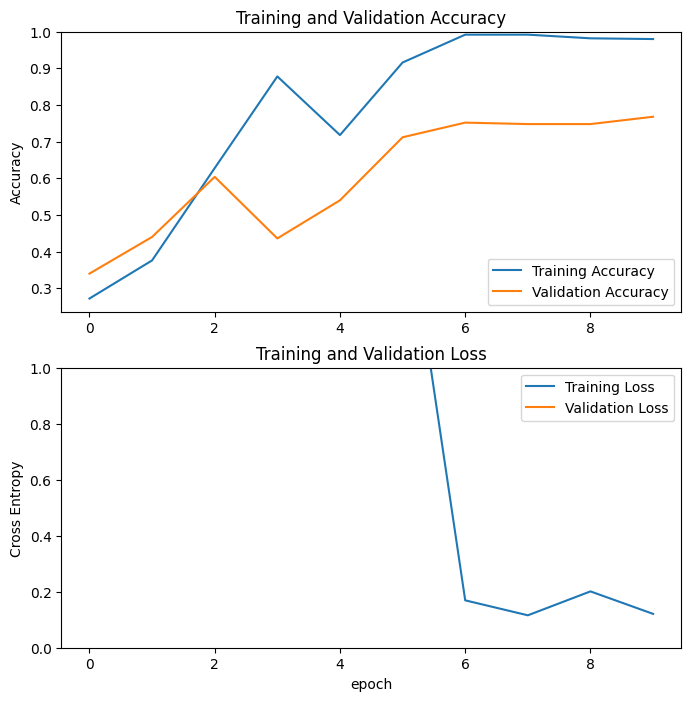

INFO:tensorflow:Assets written to: C:/Users/Rawan Alamily/Downloads/McSCert Co-op/VGG16-GradCAM/overfitted-model/saved_model4\assets


INFO:tensorflow:Assets written to: C:/Users/Rawan Alamily/Downloads/McSCert Co-op/VGG16-GradCAM/overfitted-model/saved_model4\assets


In [10]:
# plot learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

model.save(datadir+'/overfitted-model/saved_model4')

In [11]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt 

In [12]:
class GradCAM:
  def __init__(self, model, classIdx, layerName=None):
    self.model = model
    self.classIdx = classIdx
    self.layerName = layerName

    if self.layerName is None:
      for layer in (self.model.layers):
        if len(layer.output_shape) == 4:
          self.layerName = layer.name
        else:
          raise ValueError("Could not find 4D layer, GradCAM cannot be applied")
  
  def get_gradcam_heatmap(self, img, eps=1e-8):
    # add dim to img
    img = np.expand_dims(img, axis=0)

    # build model that maps input image to activations of last convolutional layer of model and the predicted output
    grad_model = tf.keras.models.Model(
        inputs=self.model.inputs,
        outputs=[self.model.get_layer(self.layerName).output, self.model.output]
    )

    # compute gradient of top predicted class for img with respect to activation of last convolutional layer
    with tf.GradientTape() as tape:
      conv_output, preds = grad_model(img)
      loss = preds[:, self.classIdx]
    grads = tape.gradient(loss, conv_output) # gradient of output neuron (predicted class) with respect to output of feature map of last convolutional layer

    # vector of mean intensity of gradient over specified feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    # get heatmap by summing all the channels after multiplying feature map by feature importance for top predicted class
    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap).numpy()

    # normalize heatmap
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")

    return heatmap

In [13]:
def build_heatmap(model, img, predictedClass, layerName, classIdx=None,
                    activation_of_truth=True):
  # get heatmap
  if activation_of_truth:
    Idx = classIdx
    if Idx == None:
      Idx = predictedClass
  else:
    Idx = predictedClass

  heatmapBuilder = GradCAM(model, Idx, layerName)
  heatmap = heatmapBuilder.get_gradcam_heatmap(img)
  heatmap = cv2.resize(heatmap, (224, 224))

  return heatmap

In [14]:
model_path = 'C:/Users/Rawan Alamily/Downloads/McSCert Co-op/VGG16-GradCAM/overfitted-model/saved_model4'
model = tf.keras.models.load_model(model_path)
model.summary()

Model: "custom_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
______________________________________________________

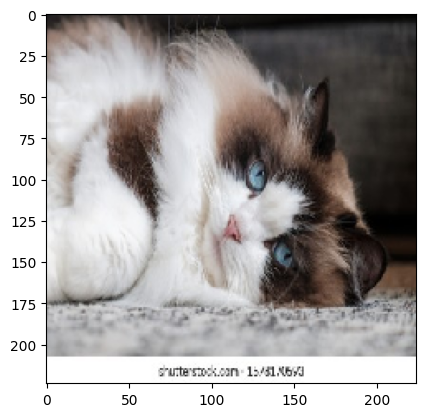

In [15]:
img_path = 'C:/Users/Rawan Alamily/Downloads/McSCert Co-op/VGG16-GradCAM/cat-breed/TEST/ragdoll/cut-rag-doll-cat-inside-260nw-1578170593.jpg'
img = tf.keras.utils.load_img(img_path, target_size=(224,224))
plt.imshow(img)

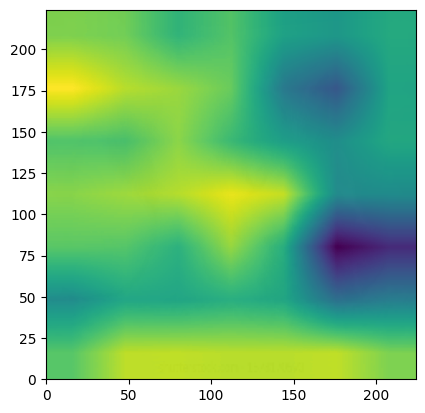

In [16]:
heatmap = build_heatmap(model, img=img, predictedClass=2, layerName='block5_pool')
extent = 0,224,0,224
fig = plt.figure(frameon=False)
plt.imshow(img, extent=extent)
plt.imshow(heatmap, cmap=plt.cm.viridis, alpha=0.99, extent=extent)
plt.show()

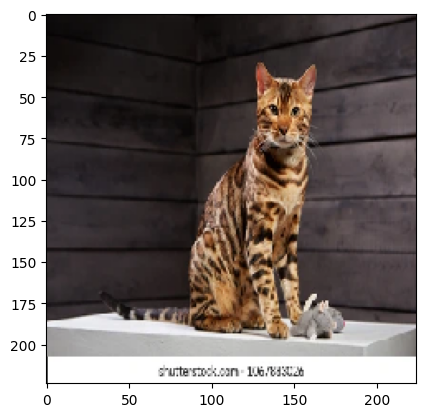

In [19]:
img_path = 'C:/Users/Rawan Alamily/Downloads/McSCert Co-op/VGG16-GradCAM/reduced-cat-breed/TEST/bengal/beautiful-cat-bengali-breed-young-260nw-1067883026.jpg'
img = tf.keras.utils.load_img(img_path, target_size=(224,224))
plt.imshow(img)

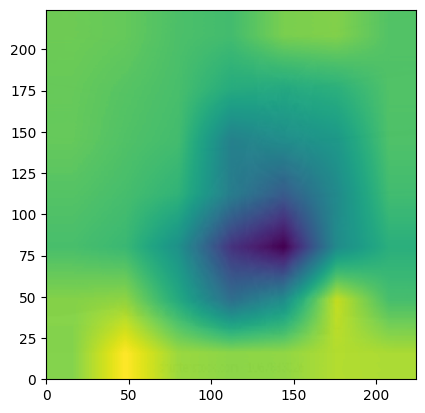

In [20]:
heatmap = build_heatmap(model, img=img, predictedClass=2, layerName='block5_pool')
extent = 0,224,0,224
fig = plt.figure(frameon=False)
plt.imshow(img, extent=extent)
plt.imshow(heatmap, cmap=plt.cm.viridis, alpha=0.99, extent=extent)
plt.show()

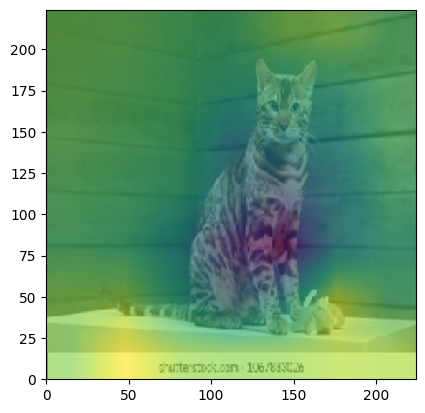

In [21]:
heatmap = build_heatmap(model, img=img, predictedClass=2, layerName='block5_pool')
extent = 0,224,0,224
fig = plt.figure(frameon=False)
plt.imshow(img, extent=extent)
plt.imshow(heatmap, cmap=plt.cm.viridis, alpha=0.65, extent=extent)
plt.show()

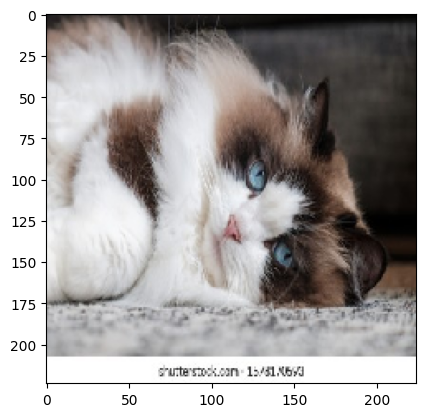

In [23]:
img_path = 'C:/Users/Rawan Alamily/Downloads/McSCert Co-op/VGG16-GradCAM/cat-breed/TEST/ragdoll/cut-rag-doll-cat-inside-260nw-1578170593.jpg'
img = tf.keras.utils.load_img(img_path, target_size=(224,224))
plt.imshow(img)

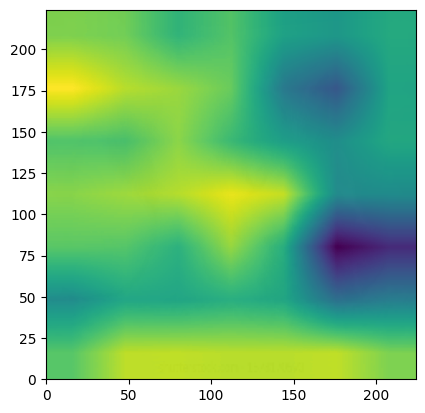

In [24]:
heatmap = build_heatmap(model, img=img, predictedClass=2, layerName='block5_pool')
extent = 0,224,0,224
fig = plt.figure(frameon=False)
plt.imshow(img, extent=extent)
plt.imshow(heatmap, cmap=plt.cm.viridis, alpha=0.99, extent=extent)
plt.show()

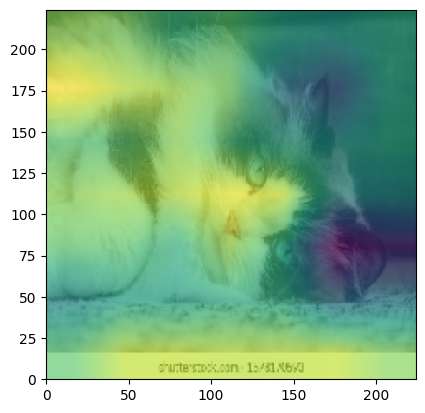

In [25]:
heatmap = build_heatmap(model, img=img, predictedClass=2, layerName='block5_pool')
extent = 0,224,0,224
fig = plt.figure(frameon=False)
plt.imshow(img, extent=extent)
plt.imshow(heatmap, cmap=plt.cm.viridis, alpha=0.65, extent=extent)
plt.show()

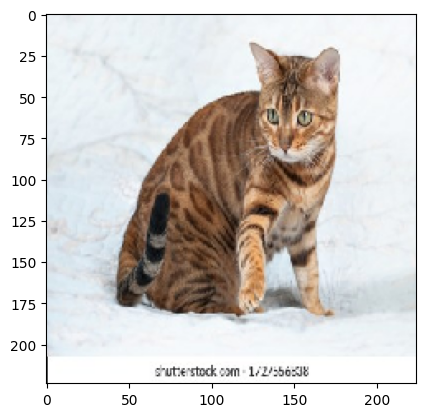

In [26]:
img_path = 'C:/Users/Rawan Alamily/Downloads/McSCert Co-op/VGG16-GradCAM/cat-breed/TEST/bengal/beautiful-goldencolored-bengal-cat-on-260nw-1727556838.jpg'
img = tf.keras.utils.load_img(img_path, target_size=(224,224))
plt.imshow(img)

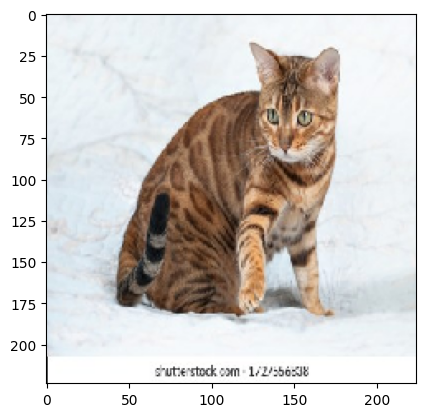

In [27]:
img_path = 'C:/Users/Rawan Alamily/Downloads/McSCert Co-op/VGG16-GradCAM/cat-breed/TEST/bengal/beautiful-goldencolored-bengal-cat-on-260nw-1727556838.jpg'
img = tf.keras.utils.load_img(img_path, target_size=(224,224))
plt.imshow(img)

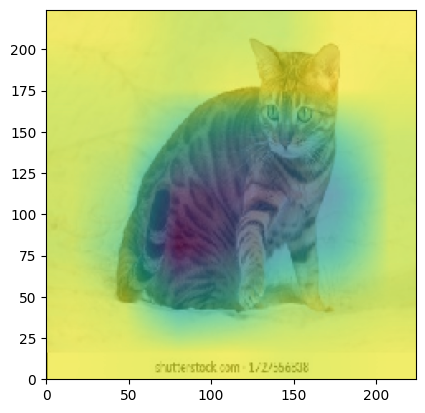

In [28]:
heatmap = build_heatmap(model, img=img, predictedClass=2, layerName='block5_pool')
extent = 0,224,0,224
fig = plt.figure(frameon=False)
plt.imshow(img, extent=extent)
plt.imshow(heatmap, cmap=plt.cm.viridis, alpha=0.65, extent=extent)
plt.show()

In [29]:
model_path = 'C:/Users/Rawan Alamily/Downloads/McSCert Co-op/VGG16-GradCAM/overfitted-model/saved_model3'
model = tf.keras.models.load_model(model_path)
model.summary()

Model: "custom_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

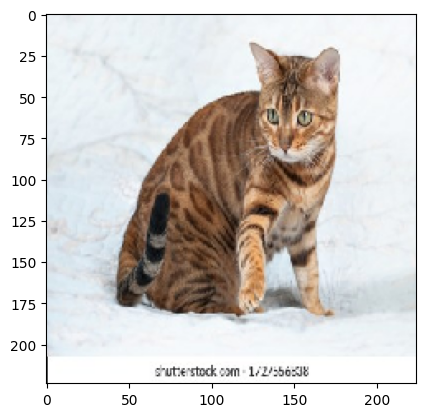

In [30]:
img_path = 'C:/Users/Rawan Alamily/Downloads/McSCert Co-op/VGG16-GradCAM/cat-breed/TEST/bengal/beautiful-goldencolored-bengal-cat-on-260nw-1727556838.jpg'
img = tf.keras.utils.load_img(img_path, target_size=(224,224))
plt.imshow(img)

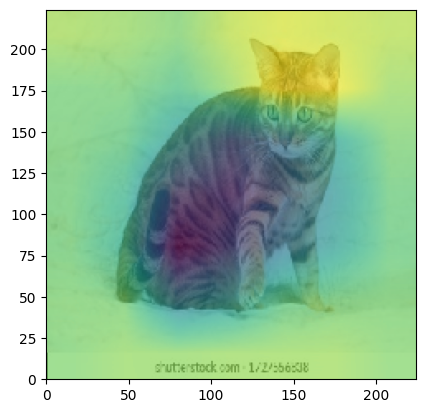

In [31]:
heatmap = build_heatmap(model, img=img, predictedClass=2, layerName='block5_pool')
extent = 0,224,0,224
fig = plt.figure(frameon=False)
plt.imshow(img, extent=extent)
plt.imshow(heatmap, cmap=plt.cm.viridis, alpha=0.65, extent=extent)
plt.show()

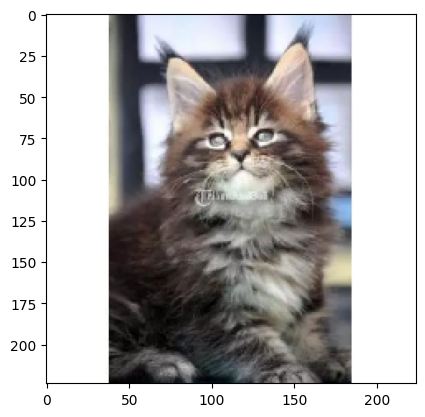

In [32]:
img_path = 'C:/Users/Rawan Alamily/Downloads/McSCert Co-op/VGG16-GradCAM/reduced-cat-breed/TRAIN/mainecoon/2-913545967-Anakan-Kucing-Maine-Coon-Murni-Kondisi-Sehat---M.jpg'
img = tf.keras.utils.load_img(img_path, target_size=(224,224))
plt.imshow(img)

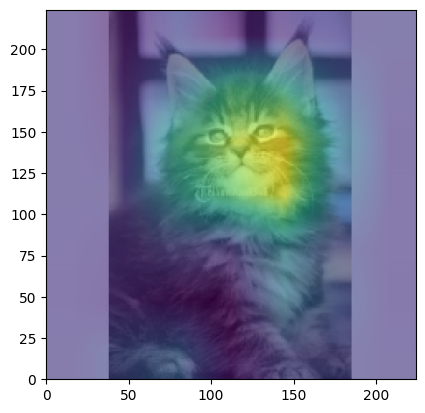

In [33]:
heatmap = build_heatmap(model, img=img, predictedClass=2, layerName='block5_pool')
extent = 0,224,0,224
fig = plt.figure(frameon=False)
plt.imshow(img, extent=extent)
plt.imshow(heatmap, cmap=plt.cm.viridis, alpha=0.65, extent=extent)
plt.show()

In [34]:
model_path = 'C:/Users/Rawan Alamily/Downloads/McSCert Co-op/VGG16-GradCAM/overfitted-model/saved_model4'
model = tf.keras.models.load_model(model_path)
model.summary()

Model: "custom_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

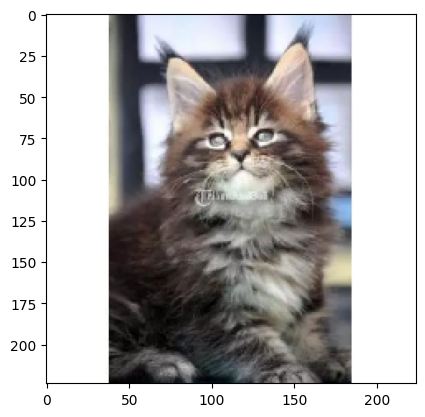

In [35]:
img_path = 'C:/Users/Rawan Alamily/Downloads/McSCert Co-op/VGG16-GradCAM/reduced-cat-breed/TRAIN/mainecoon/2-913545967-Anakan-Kucing-Maine-Coon-Murni-Kondisi-Sehat---M.jpg'
img = tf.keras.utils.load_img(img_path, target_size=(224,224))
plt.imshow(img)

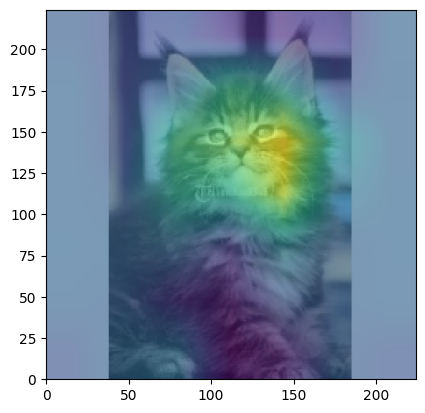

In [36]:
heatmap = build_heatmap(model, img=img, predictedClass=2, layerName='block5_pool')
extent = 0,224,0,224
fig = plt.figure(frameon=False)
plt.imshow(img, extent=extent)
plt.imshow(heatmap, cmap=plt.cm.viridis, alpha=0.65, extent=extent)
plt.show()

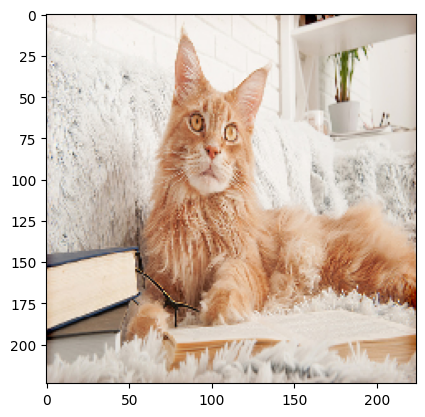

In [37]:
img_path = 'C:/Users/Rawan Alamily/Downloads/McSCert Co-op/VGG16-GradCAM/reduced-cat-breed/TRAIN/mainecoon/4-cara.jpg'
img = tf.keras.utils.load_img(img_path, target_size=(224,224))
plt.imshow(img)

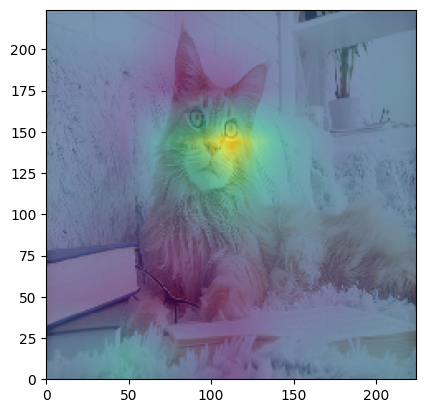

In [38]:
heatmap = build_heatmap(model, img=img, predictedClass=2, layerName='block5_pool')
extent = 0,224,0,224
fig = plt.figure(frameon=False)
plt.imshow(img, extent=extent)
plt.imshow(heatmap, cmap=plt.cm.viridis, alpha=0.65, extent=extent)
plt.show()

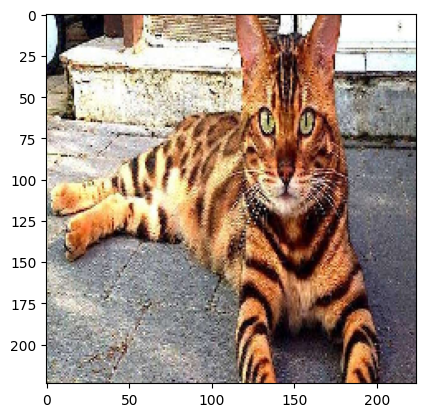

In [39]:
img_path = 'C:/Users/Rawan Alamily/Downloads/McSCert Co-op/VGG16-GradCAM/reduced-cat-breed/TRAIN/bengal/crop.jpeg'
img = tf.keras.utils.load_img(img_path, target_size=(224,224))
plt.imshow(img)

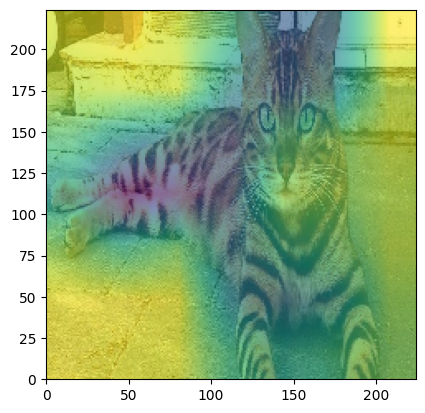

In [40]:
heatmap = build_heatmap(model, img=img, predictedClass=2, layerName='block5_pool')
extent = 0,224,0,224
fig = plt.figure(frameon=False)
plt.imshow(img, extent=extent)
plt.imshow(heatmap, cmap=plt.cm.viridis, alpha=0.65, extent=extent)
plt.show()

In [41]:
model_path = 'C:/Users/Rawan Alamily/Downloads/McSCert Co-op/VGG16-GradCAM/overfitted-model/saved_model3'
model = tf.keras.models.load_model(model_path)
model.summary()

Model: "custom_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

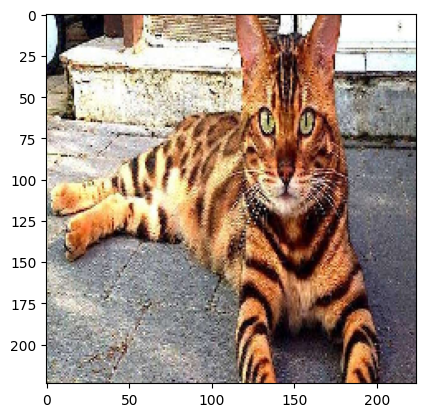

In [42]:
img_path = 'C:/Users/Rawan Alamily/Downloads/McSCert Co-op/VGG16-GradCAM/reduced-cat-breed/TRAIN/bengal/crop.jpeg'
img = tf.keras.utils.load_img(img_path, target_size=(224,224))
plt.imshow(img)

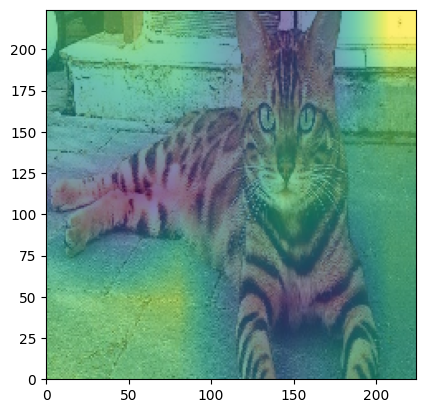

In [43]:
heatmap = build_heatmap(model, img=img, predictedClass=2, layerName='block5_pool')
extent = 0,224,0,224
fig = plt.figure(frameon=False)
plt.imshow(img, extent=extent)
plt.imshow(heatmap, cmap=plt.cm.viridis, alpha=0.65, extent=extent)
plt.show()